# CNN with Data Augmentation

En este notebook se realizará data augmentation después de haber entrenado una CNN from scratch. Esto permite mejorar la generalización del modelo al introducir variaciones artificiales en los datos de entrenamiento, lo que ayuda a prevenir el sobreajuste y a mejorar el rendimiento en datos nuevos y no vistos. 

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from keras.models import load_model
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers
from keras.applications.resnet50 import ResNet50
from keras import backend as K

2024-05-13 21:02:49.729019: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-13 21:02:49.777745: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 21:02:49.777784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 21:02:49.778972: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-13 21:02:49.786284: I tensorflow/core/platform/cpu_feature_guar

# Cargar datos

Se va a realizar la carga, preprocesamiento y visualización de los datos con el objetivo de prepararlos para su uso en modelos de redes neuronales. A continuación, se detalla el flujo de trabajo implementado:

1. **Definición de rutas y carga de imágenes**: Se especifican las rutas de acceso a las carpetas que contienen las imágenes de entrenamiento y prueba para lesiones benignas y malignas. Las imágenes se cargan en memoria, convirtiéndolas al formato RGB para garantizar la consistencia en la representación de color.

2. **Generación de etiquetas**: Para cada imagen, se asigna una etiqueta numérica que indica si la lesión es benigna (0) o maligna (1). Este proceso se realiza tanto para el conjunto de entrenamiento como de prueba.

3. **Combinación y barajado de datos**: Los datos de imágenes y etiquetas se combinan y luego se barajan aleatoriamente. Este paso es crucial para evitar cualquier sesgo durante el entrenamiento del modelo, asegurando que la distribución de los ejemplos sea uniforme.

4. **Visualización de los datos**: Finalmente, se visualiza una selección de imágenes del conjunto de entrenamiento. Cada imagen se muestra con su respectiva etiqueta, permitiendo una verificación visual rápida de la correcta carga y etiquetado de los datos.


In [2]:
folder_benign_train = 'data/train/benign'
folder_malignant_train = 'data/train/malignant'

folder_benign_test = 'data/test/benign'
folder_malignant_test = 'data/test/malignant'

In [3]:
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

In [4]:
# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

In [5]:
# Merge data
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

In [6]:
# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

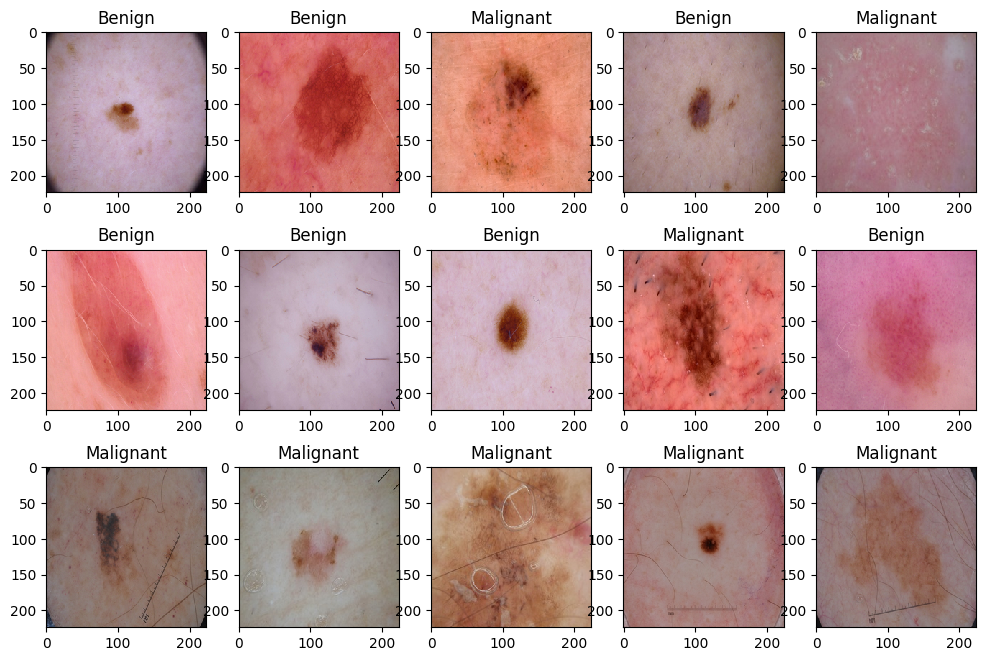

In [7]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

# Convertir etiquetas a categóricas

In [8]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

# Normalizar
Se realiza una normalización de los valores de píxeles de las imágenes tanto en el conjunto de entrenamiento como en el de prueba. Cada valor de píxel, originalmente en el rango de 0 a 255, se divide por 255 para obtener valores en el rango de 0 a 1. De esta manera se mejora la convergencia del modelo durante el entrenamiento, asegurando que todos los píxeles contribuyan equitativamente al aprendizaje y que los procesos computacionales se optimicen.

In [9]:
X_train = X_train/255.
X_test = X_test/255.

# Data Augmentation

A continuación se utilizará la clase ImageDataGenerator de Keras para generar lotes de datos de imágenes con aumentación y normalización. Se configurarán diferentes transformaciones como rotación, desplazamiento, cambio de escala y volteo horizontal para el conjunto de entrenamiento. 

In [10]:
train_dir = "./data/train"
test_dir = "./data/test"

train_beningn_dir = "./data/train/benign"
train_malignant_dir = "./data/train/malignant"

test_beningn_dir = "./data/test/benign"
test_malignant_dir = "./data/test/malignant"

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

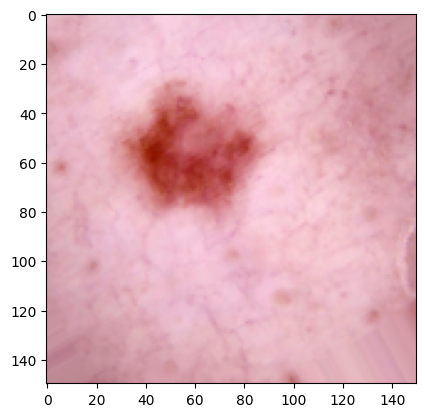

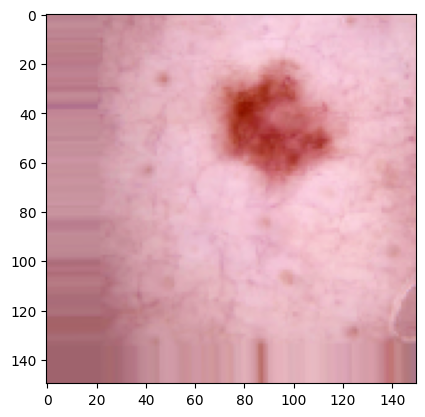

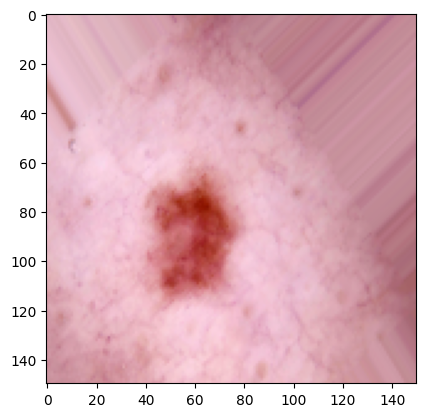

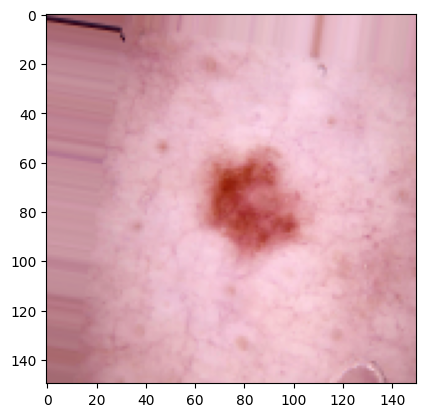

In [12]:
# This is module with image preprocessing utilities
from tensorflow.keras.preprocessing import image

fnames = [os.path.join(train_beningn_dir, fname) for fname in os.listdir(train_beningn_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


# Construir el modelo

### Arquitectura del Modelo

1. **Capa de entrada**: El modelo inicia con una capa convolucional que utiliza 32 filtros de tamaño 3x3 y función de activación ReLU. Esta capa es responsable de extraer las primeras características visuales básicas, como bordes y texturas, de las imágenes de entrada. La forma de entrada se define según el tamaño de las imágenes del conjunto de datos, que en este caso es de 224x224 píxeles y 3 canales de color (RGB).

2. **Capas de convolución y agrupamiento**: Se suceden varias capas convolucionales y de max pooling. Las capas convolucionales aumentan en número de filtros de 32 a 64 y luego a 128, permitiendo al modelo capturar características cada vez más complejas y abstractas. Las capas de max pooling (2x2) reducen progresivamente las dimensiones espaciales de los mapas de características, ayudando a hacer el modelo más eficiente y menos susceptible a las variaciones de posición de las características en las imágenes.

3. **Aplanamiento y capas densas**: Tras las capas convolucionales y de pooling, los mapas de características se aplanan en un vector largo, que se procesa a través de capas densas (fully connected). La primera capa densa tiene 128 neuronas, seguida de una capa de salida con 2 neuronas, cada una correspondiente a una clase del problema (benigno y maligno).

4. **Capa de salida**: La última capa utiliza la función de activación sigmoid, que es adecuada para clasificación binaria.


In [18]:
input_shape = (224, 224, 3)

# Creando el modelo de la red neuronal
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))  # Una capa de max pooling adicional para manejar el aumento de tamaño de la imagen
model.add(layers.Conv2D(128, (3, 3), activation='relu'))  # Capa adicional para más complejidad
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))  # Dos clases de salida: benigno (0) y maligno (1)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     9,437,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,567,617 (36.50 MB)

 Trainable params: 9,567,617 (36.50 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Cambio en la función de pérdida para clasificación binaria
              metrics=['accuracy'])

In [21]:
history = model.fit(
      train_generator,
      steps_per_epoch = 25, #100
      epochs = 20, #100
      validation_data = test_generator,
      validation_steps = 5) #50

Epoch 1/20


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-13 21:04:00.920058: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f89a000f4f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-13 21:04:00.920103: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-05-13 21:04:00.974628: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-13 21:04:01.315371: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc

 1/25 ━━━━━━━━━━━━━━━━━━━━ 5:31 14s/step - accuracy: 0.5312 - loss: 0.9474

I0000 00:00:1715634250.165752   42969 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715634250.183303   42969 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.5698 - loss: 0.9272

W0000 00:00:1715634266.660998   42970 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 695ms/step - accuracy: 0.5699 - loss: 0.9242 - val_accuracy: 0.6812 - val_loss: 0.7267
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 362ms/step - accuracy: 0.6906 - loss: 0.6770 - val_accuracy: 0.7937 - val_loss: 0.5660
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 370ms/step - accuracy: 0.6984 - loss: 0.5880 - val_accuracy: 0.7750 - val_loss: 0.5514
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7850 - loss: 0.5812 - val_accuracy: 0.7125 - val_loss: 0.5220
Epoch 5/20


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 441ms/step - accuracy: 0.7239 - loss: 0.5732 - val_accuracy: 0.8500 - val_loss: 0.3906
Epoch 6/20
 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6250 - loss: 0.6194

2024-05-13 21:04:58.758428: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2979537965220512737
2024-05-13 21:04:58.758500: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 237747144826496456


25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 347ms/step - accuracy: 0.7436 - loss: 0.5311 - val_accuracy: 0.7750 - val_loss: 0.5045
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 358ms/step - accuracy: 0.7594 - loss: 0.4910 - val_accuracy: 0.7563 - val_loss: 0.4825
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7228 - loss: 0.5358 - val_accuracy: 0.7875 - val_loss: 0.4764
Epoch 9/20


2024-05-13 21:05:16.279976: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2979537965220512737
2024-05-13 21:05:16.280041: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 237747144826496456


25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.7517 - loss: 0.5145 - val_accuracy: 0.6938 - val_loss: 0.5255
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 350ms/step - accuracy: 0.7661 - loss: 0.5019 - val_accuracy: 0.7500 - val_loss: 0.4413
Epoch 11/20


2024-05-13 21:05:36.454458: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2979537965220512737


25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 361ms/step - accuracy: 0.7975 - loss: 0.4475 - val_accuracy: 0.7312 - val_loss: 0.5204
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8066 - loss: 0.4175 - val_accuracy: 0.8562 - val_loss: 0.3209
Epoch 13/20


2024-05-13 21:05:45.813445: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2979537965220512737
2024-05-13 21:05:45.813501: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 237747144826496456


25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.7801 - loss: 0.4890 - val_accuracy: 0.7500 - val_loss: 0.4940
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 350ms/step - accuracy: 0.7887 - loss: 0.4359 - val_accuracy: 0.7688 - val_loss: 0.4641
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 351ms/step - accuracy: 0.7912 - loss: 0.4648 - val_accuracy: 0.8500 - val_loss: 0.3928
Epoch 16/20


2024-05-13 21:06:14.742461: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2979537965220512737


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7391 - loss: 0.5117 - val_accuracy: 0.7937 - val_loss: 0.4730
Epoch 17/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7755 - loss: 0.4834 - val_accuracy: 0.8000 - val_loss: 0.4671
Epoch 18/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 345ms/step - accuracy: 0.7714 - loss: 0.4996 - val_accuracy: 0.7750 - val_loss: 0.4939
Epoch 19/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 349ms/step - accuracy: 0.8067 - loss: 0.4635 - val_accuracy: 0.7812 - val_loss: 0.4577
Epoch 20/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7654 - loss: 0.4861 - val_accuracy: 0.9000 - val_loss: 0.2930


2024-05-13 21:06:45.130633: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2979537965220512737


In [22]:
model.save('models/cnn_data-augmentation.h5')

In [23]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


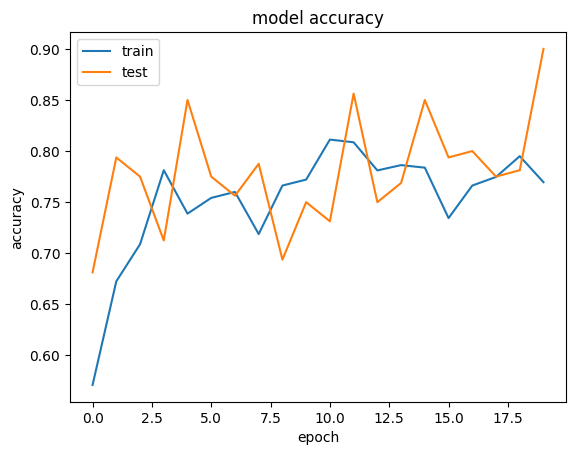

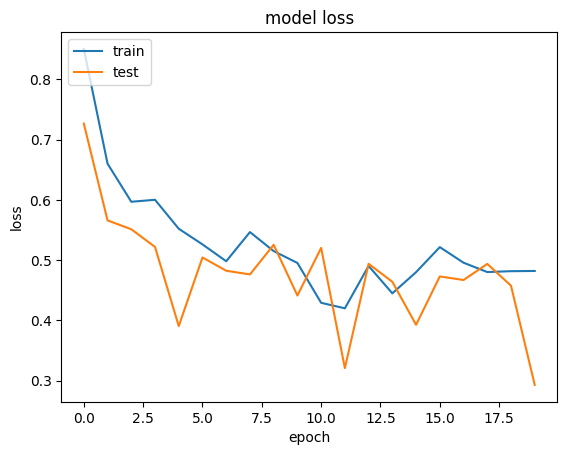

<Figure size 640x480 with 0 Axes>

In [24]:
#print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('images/acc-aug.png')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('images/loss-aug.png')

+ Gráfica de accuracy: Independientemente de las fluctuaciones en ambas curvas, la tendencia general es ascendente. Aunque se observe una clara diferencia en la precisión del conjunto de validación frente al de entrenamiento al final de la gráfica, la volatilidad de la gráfica no nos permite sacar conslusiones claras más allá de la tendencia ascendante. No se puede afirmar que hay overfit.

+ Gráfica de loss: Al igual que en el caso del accuracy, la gráfica de pérdida presenta numerosos picos, pero su tendencia es descendente. Todo parece indicar que las predicciones en el conjunto de validación mejoran a medida que se avanza.

# Predicciones

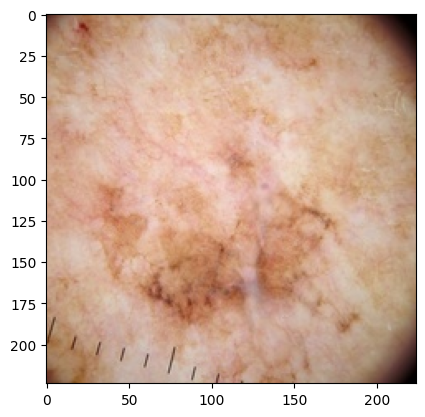

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
[[0.7467874]]
Maligno


In [25]:
# cargar modelo
model = load_model('models/cnn_data-augmentation.h5')

# cargar imagen
img = Image.open('data/test/malignant/1.jpg')
img = img.resize((224, 224))
img = np.array(img)
img = img/255.
img = img.reshape(1,224,224,3)

# mostrar imagen
plt.imshow(img[0])
plt.show()

# predecir
pred = model.predict(img)
print(pred)
if pred[0][0] < 0.5:
    print('Benigno')
else:
    print('Maligno')


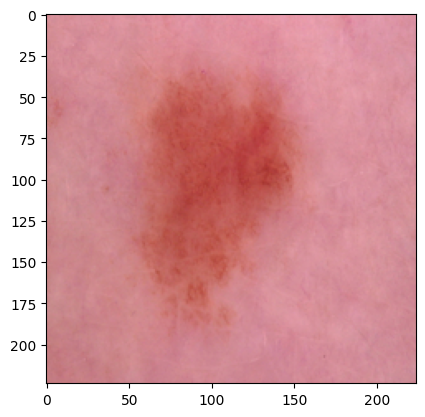

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
[[0.02905374]]
Benigno


In [26]:
# cargar modelo
model = load_model('models/cnn_data-augmentation.h5')

# cargar imagen
img = Image.open('data/test/benign/57.jpg')
img = img.resize((224, 224))
img = np.array(img)
img = img/255.
img = img.reshape(1,224,224,3)

# mostrar imagen
plt.imshow(img[0])
plt.show()

# predecir
pred = model.predict(img)
print(pred)
if pred[0][0] < 0.5:
    print('Benigno')
else:
    print('Maligno')
